# RealNVP_Simple ver.

#### Dependencies

In [1]:
import numpy as np
import pickle
import math
from sys import exit
import matplotlib.pyplot as plt
from sklearn import datasets
import argparse

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional
import pdb

torch.set_default_dtype(torch.float64) #use double precision numbers

## --Affine Coupling--

#### Now we will be creating a simple Affine coupling layer class which will compute the scale & transformation, along with producing the log-determinant from normal & inverse forwarding.

please note to use the below function to derive x & y in the inverse and forward function.


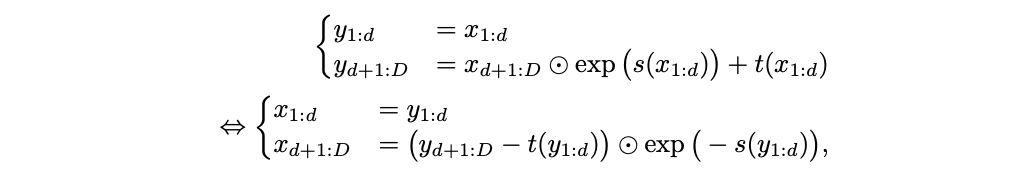

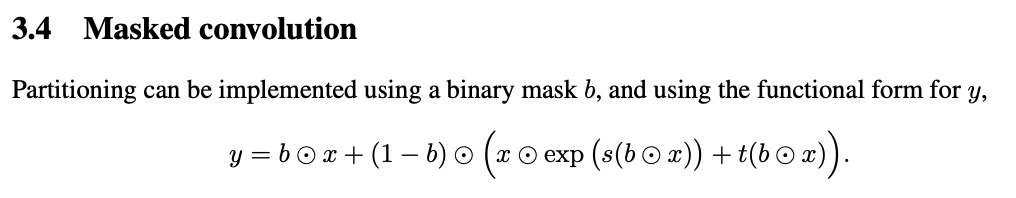

In [2]:
class Affine_Coupling(nn.Module):
    def __init__(self, mask, hidden_dim): # ex) mask = [1.0,0.0] , hidden_dim=128
        super(Affine_Coupling, self).__init__()
        self.input_dim = len(mask) # 2
        self.hidden_dim = hidden_dim

        ## mask to seperate positions that do not change and positions that change.
        ## mask[i] = 1 means the ith position does not change.
        self.mask = nn.Parameter(mask, requires_grad = False)
        # self.mask = Parameter containing: tensor([1., 0.])

        ## layers used to compute scale in affine transformation
        ## please make 3 Linear transform layers which would transform:
        ## 1st layer : input size of "input_dim" to "hidden_dim"
        ## 2nd layer : input size of "hidden_dim" to "hidden_dim"
        ## 3rd layer : input size of "hidden_dim" to "input_dim"
        ## and finally, create a "scale" variable which would serve as a learnable Parameter
        ## to learn the scaling. (This should be a vector of size input_dim)
        ###============Code==============
        self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)# 2 -> 128
        self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)# 128 -> 128
        self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)# 128 -> 2
        self.scale = nn.Parameter(torch.Tensor(self.input_dim))
        ###============Code==============???
        init.normal_(self.scale)

        ## layers used to compute translation in affine transformation
        ## please make 3 Linear transform layers which would transform:
        ## 1st layer : input size of "input_dim" to "hidden_dim"
        ## 2nd layer : input size of "hidden_dim" to "hidden_dim"
        ## 3rd layer : input size of "hidden_dim" to "input_dim"

        ###============Code==============
        self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
        ###============Code==============


    def _compute_scale(self, x):
        ## compute scaling factor using unchanged part of x with a neural network
        ## please make 3 relu layers which would transform:
        ## 1st layer : applies relu to the output from 1st linear layer for scaling (input would be ...?).
        ## 2nd layer : applies relu to the output from 2nd linear layer for scaling (sequentially applied, so input should be...?)
        ## 3rd layer : applies relu to the output from 3rd linear layer for scaling (sequentially applied, so input should be...?)
        ## However, the last layer should apply element-wise multiplication with scale parameter.
        ## And finally return the output from the final operation.

        ###============Code==============
        s = torch.relu(self.scale_fc1(x*self.mask))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s)) * self.scale # self.scale : [ 2.1864, -0.5454]
        return s
        ###============Code==============

    def _compute_translation(self, x):
        ## compute translation using unchanged part of x with a neural network
        ## please make 2 relu layers which would transform:
        ## 1st layer : applies relu to the output from 1st linear layer for translation (input would be ...?).
        ## 2nd layer : applies relu to the output from 2nd linear layer for translation (sequentially applied, so input should be...?)
        ## you need apply the last linear layer for translation without any other operation.
        ## And finally return the output from the final operation.

        ###============Code==============
        t = torch.relu(self.translation_fc1(x*self.mask))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)
        return t
        ###============Code==============

    def forward(self, x):
        ## convert latent space variable to observed variable
        ## - get s (scale) and t (transformation)
        ## - Using the above formula, compute & return "y" and "log-determinant"
        ## for exponential, use torch.exp()

        ###============Code==============
        s = self._compute_scale(x)
        t = self._compute_translation(x)

        y = self.mask*x + (1-self.mask)*(x*torch.exp(s) + t)
        logdet = torch.sum((1 - self.mask)*s, -1)

        return y, logdet
        ###============Code==============

    def inverse(self, y):
        ## convert observed varible to latent space variable
        ## - get s (scale) and t (transformation)
        ##  -CAUTION: it is inverse!
        ## Using the above formula, compute & return "x" and "log-determinant"
        ## for exponential, use torch.exp()

        ###============Code==============
        s = self._compute_scale(y)
        t = self._compute_translation(y)

        x = self.mask*y + (1-self.mask)*((y - t)*torch.exp(-s))
        logdet = torch.sum((1 - self.mask)*(-s), -1)

        return x, logdet
        ###============Code==============

In [3]:
class RealNVP_2D(nn.Module):
    '''
    A vanilla RealNVP class for modeling 2 dimensional distributions
    '''
    def __init__(self, masks, hidden_dim): # mask : 1*2 of 8 tensor // hid :128
        '''
        initialized with a list of masks. each mask define an affine coupling layer
        '''
        super(RealNVP_2D, self).__init__()
        self.hidden_dim = hidden_dim

        ## Create a parameterlist for masks (checkerboard)
        ## *** self.masks should look like:
        # masks:  [[1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0],
        #         [0.0, 1.0], [1.0, 0.0], [0.0, 1.0]]
        ###============Code==============
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m),requires_grad = False)
             for m in masks])
        ###============Code==============

        ## Create Coupling layer blocks where the number of blocks should be
        ## equal to the length of self.masks.
        ###============Code==============
        self.affine_couplings = nn.ModuleList(
            [Affine_Coupling(self.masks[i], self.hidden_dim)
             for i in range(len(self.masks))])
        ###============Code==============

    def forward(self, x):
        ## convert latent space variables into observed variables
        y = x
        logdet_tot = 0

        ## cumulatively add the determinant produced from affine coupling blocks
        ## *** The output of the coupling block should be tuple of two variables.
        ## The first output should be continually passed to the next blocks. Then how
        ## should it be implemented...?

        ###============Code==============
        for i in range(len(self.affine_couplings)):
            y, logdet = self.affine_couplings[i](y)
            logdet_tot = logdet_tot + logdet
        ###============Code==============

        ## a normalization layer is added such that the observed variables is within
        ## the range of [-4, 4].

        ## ===Don't know whether this part should be "coded" <squeezing part>===
        logdet = torch.sum(torch.log(torch.abs(4*(1-(torch.tanh(y))**2))), -1)
        y = 4*torch.tanh(y)
        logdet_tot = logdet_tot + logdet

        return y, logdet_tot
        # ==============================

    def inverse(self, y):
        ## convert observed variables into latent space variables
        x = y
        logdet_tot = 0

        # inverse the normalization layer
        ## ===Don't know whether this part should be "coded" <squeezing part>===
        logdet = torch.sum(torch.log(torch.abs(1.0/4.0* 1/(1-(x/4)**2))), -1)
        x  = 0.5*torch.log((1+x/4)/(1-x/4))
        logdet_tot = logdet_tot + logdet
        ## ================================================

        ## inverse affine coupling layers
        ## cumulatively add the determinant produced from affine coupling blocks
        ## *** The output of the coupling block should be tuple of two variables.
        ## The first output should be continually passed to the next blocks. Then how
        ## should it be implemented...?
        ## IMPORTANT: This is a inverse, so ALL the things should go "backwards!"

        ###============Code==============
        for i in range(len(self.affine_couplings)-1, -1, -1):
            x, logdet = self.affine_couplings[i].inverse(x)
            logdet_tot = logdet_tot + logdet

        return x, logdet_tot
        ###============Code==============

RealNVP_2D(
  (masks): ParameterList(
      (0): Parameter containing: [torch.float64 of size 2]
      (1): Parameter containing: [torch.float64 of size 2]
      (2): Parameter containing: [torch.float64 of size 2]
      (3): Parameter containing: [torch.float64 of size 2]
      (4): Parameter containing: [torch.float64 of size 2]
      (5): Parameter containing: [torch.float64 of size 2]
      (6): Parameter containing: [torch.float64 of size 2]
      (7): Parameter containing: [torch.float64 of size 2]
  )
  (affine_couplings): ModuleList(
    (0-7): 8 x Affine_Coupling(
      (scale_fc1): Linear(in_features=2, out_features=128, bias=True)
      (scale_fc2): Linear(in_features=128, out_features=128, bias=True)
      (scale_fc3): Linear(in_features=128, out_features=2, bias=True)
      (translation_fc1): Linear(in_features=2, out_features=128, bias=True)
      (translation_fc2): Linear(in_features=128, out_features=128, bias=True)
      (translation_fc3): Linear(in_features=128, out_f

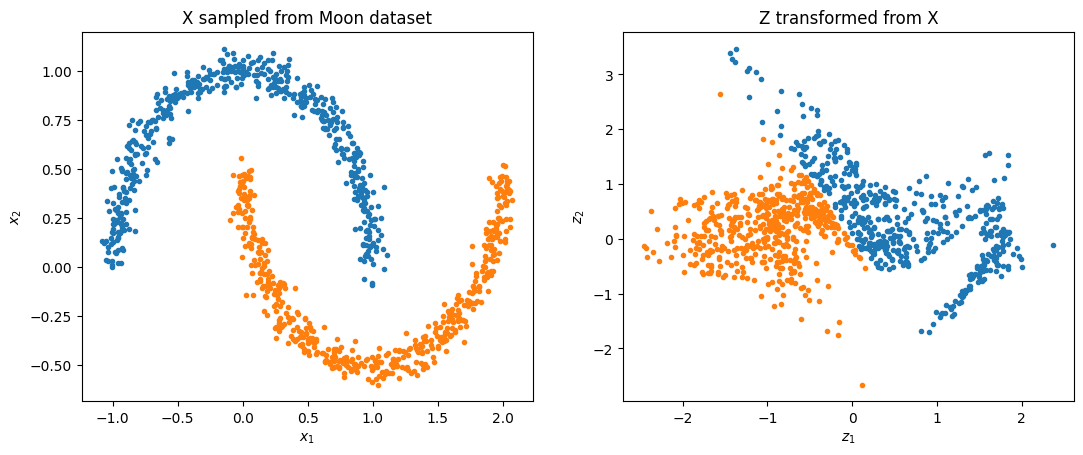

In [5]:
## Masks used to define the number and the type of affine coupling layers
## In each mask, 1 means that the variable at the correspoding position is
## kept fixed in the affine couling layer
masks = [[1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],
         [0.0, 1.0]]

## dimenstion of hidden units used in scale and translation transformation
hidden_dim = 128

## construct the RealNVP_2D object
realNVP = RealNVP_2D(masks, hidden_dim)
if torch.cuda.device_count():
    realNVP = realNVP.cuda()
device = next(realNVP.parameters()).device

optimizer = optim.Adam(realNVP.parameters(), lr = 0.0001)

print(realNVP)

num_steps = 5000
# num_steps = 5000

## the following loop learns the RealNVP_2D model by data
## in each loop, data is dynamically sampled from the scipy moon dataset
for idx_step in range(num_steps):
    ## sample data from the scipy moon dataset
    X, label = datasets.make_moons(n_samples = 512, noise = 0.05)

    X = torch.Tensor(X).to(device = device)
    if(idx_step == 0):
      print(X.shape)
      print(label.shape)

    ## transform data X to latent space Z
    z, logdet = realNVP.inverse(X)

    ## calculate the negative loglikelihood of X
    loss = torch.log(z.new_tensor([2*math.pi])) + torch.mean(torch.sum(0.5*z**2, -1) - logdet)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if (idx_step + 1) % 100 == 0:
        print(f"idx_steps: {idx_step:}, loss: {loss.item():.5f}")

## after learning, we can test if the model can transform
## the moon data distribution into the normal distribution
X, label = datasets.make_moons(n_samples = 1000, noise = 0.05)
X = torch.Tensor(X).to(device = device)
z, logdet_jacobian = realNVP.inverse(X)
z = z.cpu().detach().numpy()

X = X.cpu().detach().numpy()
fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(X[label==0,0], X[label==0,1], ".")
plt.plot(X[label==1,0], X[label==1,1], ".")
plt.title("X sampled from Moon dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.subplot(1,2,2)
plt.plot(z[label==0,0], z[label==0,1], ".")
plt.plot(z[label==1,0], z[label==1,1], ".")
plt.title("Z transformed from X")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.show()